In [1]:
import sys
import xarray as xr
import numpy as np
import Plotter
from Plotter import Plotter
import time
from preprocessing_utils_sampling import *
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn import metrics
import pyxpcm
from pyxpcm.models import pcm
import warnings
import glob
import seaborn as sns
from joblib import dump, load

from joblib import Parallel, delayed
import multiprocessing

warnings.filterwarnings('ignore')

In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
def score_model(m, m_full, x):
    pred = m.predict(x)
    truth = m_full.predict(x)
    print("sample")
    print(f"model score (higher is best): {m.score(x)}")
#     print(f"silhouette score (closer to 1 is best): {metrics.silhouette_score(x, pred)}")
    print("---------------------------------------------------")
    print("full")
    print(f"model score (higher is best): {m_full.score(x)}")
#     print(f"silhouette score (closer to 1 is best): {metrics.silhouette_score(x, truth)}")
    print("---------------------------------------------------")
    print(f" adjusted rand score: {metrics.adjusted_rand_score(truth, pred)}")
    print(f" unadjusted rand score: {metrics.rand_score(truth, pred)}")
    print("---------------------------------------------------")
    print(f" adjusted mutual info score: {metrics.adjusted_mutual_info_score(truth, pred)}")
    print(f" unadjusted mutual info score: {metrics.mutual_info_score(truth, pred)}")

#     print(f"model score: {m.score(x)}")
#     print(f"model score: {m.score(x)}")

In [4]:
def score_iter(m, m_full, x):
    pred = m.predict(x)
    truth = m_full.predict(x)
    return m.score(x), metrics.rand_score(truth, pred), metrics.mutual_info_score(truth, pred)

In [5]:
def predict(x, m, var_name_ds, k, var_predict):
    classif = m.predict(x[var_predict])
    return classif

In [6]:
def assign_pred(x, classif, k, var_name_ds):
    x = x.assign(variables={"labels": ('sample_dim', classif)})
    q = [0.05, 0.5, 0.95]
    x = compute_quantile(x, var_name_ds, k, q)
    x = x.assign_coords(coords={'k': range(k)})
#     x = x.unstack('sample_dim')
    return x

# Execution of the code

## parameters

In [7]:
var_name_ds = 'TEMP'
k = 6

## Argopy profiles

In [61]:
%%time
from argopy import DataFetcher as ArgoDataFetcher

wmos_list = np.loadtxt('../datasets/wmos_list.txt', dtype=int).tolist()

argo_loader = ArgoDataFetcher(parallel=True,progress=True)
ds_argo_init = argo_loader.region([-6,42,30.,46.,0,400.,'2019-01','2019-12']).to_xarray()
# for wmo in wmos_list:
# #     ds_argo_init = argo_loader.float(wmo=wmo).to_xarray()
ds_argo_init.to_netcdf(f'../datasets/argo_med/date_2019.nc')


100%|██████████| 12/12 [00:40<00:00,  3.35s/it]


CPU times: user 15.1 s, sys: 2.53 s, total: 17.6 s
Wall time: 56 s


In [62]:
ds_argo_init = xr.open_mfdataset('../datasets/argo_med/*.nc').load()
ds_argo_init

<xarray.Dataset>
Dimensions:                (N_POINTS: 1105502)
Coordinates:
  * N_POINTS               (N_POINTS) int64 0 1 2 3 ... 1105499 1105500 1105501
    LATITUDE               (N_POINTS) float64 39.72 39.72 39.72 ... 34.24 34.24
    LONGITUDE              (N_POINTS) float64 7.517 7.517 7.517 ... 25.94 25.94
    TIME                   (N_POINTS) datetime64[ns] 2019-01-02T10:17:00 ... ...
Data variables: (12/13)
    CONFIG_MISSION_NUMBER  (N_POINTS) int64 5 5 5 5 5 5 5 5 ... 3 3 3 3 3 3 3 3
    CYCLE_NUMBER           (N_POINTS) int64 34 34 34 34 34 34 ... 65 65 65 65 65
    DATA_MODE              (N_POINTS) object 'D' 'D' 'D' 'D' ... 'R' 'R' 'R' 'R'
    DIRECTION              (N_POINTS) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER        (N_POINTS) int64 6901657 6901657 ... 3901977 3901977
    POSITION_QC            (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    ...                     ...
    PRES_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PSAL                   (N_POINTS) float32 37.67 37.67 37.67 ... 39.26 39.26
    PSAL_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP                   (N_POINTS) float32 15.6 15.6 15.6 ... 16.18 16.15
    TEMP_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC                (N_POINTS) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           lbachelo
    Fetched_date:         2021/05/10
    Fetched_constraints:  [x=-6.00/42.00; y=30.00/46.00; z=0.0/400.0; t=2012-...
    Fetched_uri:          ['https://www.ifremer.fr/erddap/tabledap/ArgoFloats...
    history:              Variables filtered according to DATA_MODE; Variable...

In [63]:
ds_argo = ds_argo_init.argo.point2profile()
# interpolation to standard levels
z = np.arange(0.,400,10.)
ds_argo = ds_argo.argo.interp_std_levels(z)

# pressure should be negative
ds_argo['PRES_INTERPOLATED'] = -np.abs(ds_argo['PRES_INTERPOLATED'].values)
# depth attribute 'axis' for Plotter instance
ds_argo.PRES_INTERPOLATED.attrs['axis'] = 'Z'
ds_argo = ds_argo.rename({'PRES_INTERPOLATED': 'depth', 'N_PROF': 'sample_dim'})
ds_argo

<xarray.Dataset>
Dimensions:                (depth: 40, sample_dim: 4657)
Coordinates:
  * sample_dim             (sample_dim) int64 1851 1060 3736 ... 3189 4549 2044
    LATITUDE               (sample_dim) float64 41.8 35.1 34.89 ... 38.65 41.38
    LONGITUDE              (sample_dim) float64 39.5 27.43 27.44 ... 10.85 40.54
    TIME                   (sample_dim) datetime64[ns] 2019-01-01T00:04:00 .....
  * depth                  (depth) float64 -0.0 -10.0 -20.0 ... -380.0 -390.0
Data variables:
    CONFIG_MISSION_NUMBER  (sample_dim) float64 3.0 3.0 3.0 7.0 ... 7.0 3.0 2.0
    CYCLE_NUMBER           (sample_dim) float64 315.0 15.0 28.0 ... 149.0 294.0
    DATA_MODE              (sample_dim) object 'D' 'R' 'R' 'R' ... 'R' 'R' 'D'
    DIRECTION              (sample_dim) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    PLATFORM_NUMBER        (sample_dim) float64 6.902e+06 ... 6.902e+06
    PRES                   (sample_dim, depth) float32 7.7 10.0 ... 380.0 390.0
    PSAL                   (sample_dim, depth) float32 18.37 18.37 ... 21.91
    TEMP                   (sample_dim, depth) float32 11.44 11.44 ... 8.875
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           lbachelo
    Fetched_date:         2021/05/10
    Fetched_constraints:  [x=-6.00/42.00; y=30.00/46.00; z=0.0/400.0; t=2012-...
    Fetched_uri:          ['https://www.ifremer.fr/erddap/tabledap/ArgoFloats...
    history:              Variables filtered according to DATA_MODE; Variable...

In [64]:
ds_argo.to_netcdf('../datasets/argo_profiles_2012-2019.nc')

In [12]:
ds_argo = xr.open_dataset('../datasets/argo_profiles_float100.nc')

In [65]:
print(ds_argo['LONGITUDE'].max())
print(ds_argo['LONGITUDE'].min())
print(ds_argo['LATITUDE'].max())
print(ds_argo['LATITUDE'].min())

<xarray.DataArray 'LONGITUDE' ()>
array(41.39265167)
<xarray.DataArray 'LONGITUDE' ()>
array(-5.48)
<xarray.DataArray 'LATITUDE' ()>
array(45.938)
<xarray.DataArray 'LATITUDE' ()>
array(31.45975167)


## Load and preprocessing
see in file preprocessing utils for details

In [66]:
spacial_domain = {"lon":[-6, 42],
                 "lat": [30, 46],
                 "depth": 1000}

x =  ds_argo[[var_name_ds]]

x = x.dropna(dim='sample_dim', how='any')
# x = x.transpose()
x, _ = standard_scaling(x, backend='sk', var_name=var_name_ds)
x, _ = fit_pca(x=x, n_comp=15, var_name=var_name_ds + '_scaled', backend='sk')
x

<xarray.Dataset>
Dimensions:              (depth: 40, depth_reduced: 15, sample_dim: 4657)
Coordinates:
  * sample_dim           (sample_dim) int64 1851 1060 3736 ... 3189 4549 2044
    LATITUDE             (sample_dim) float64 41.8 35.1 34.89 ... 38.65 41.38
    LONGITUDE            (sample_dim) float64 39.5 27.43 27.44 ... 10.85 40.54
    TIME                 (sample_dim) datetime64[ns] 2019-01-01T00:04:00 ... ...
  * depth                (depth) float64 -0.0 -10.0 -20.0 ... -380.0 -390.0
Dimensions without coordinates: depth_reduced
Data variables:
    TEMP                 (sample_dim, depth) float32 11.44 11.44 ... 8.873 8.875
    TEMP_scaled          (sample_dim, depth) float32 -1.739 -1.72 ... -2.516
    TEMP_scaled_reduced  (sample_dim, depth_reduced) float32 14.71 ... -0.00523
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           lbachelo
    Fetched_date:         2021/05/10
    Fetched_constraints:  [x=-6.00/42.00; y=30.00/46.00; z=0.0/400.0; t=2012-...
    Fetched_uri:          ['https://www.ifremer.fr/erddap/tabledap/ArgoFloats...
    history:              Variables filtered according to DATA_MODE; Variable...

## Training

In [67]:
var_train = var_name_ds + "_scaled_reduced"

In [68]:
%%time
m_full = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-8, n_init=1)
m_full.fit(x[var_train])
# m_full = load('modelk6_full_10y.joblib')

CPU times: user 2.89 s, sys: 4.32 s, total: 7.21 s
Wall time: 933 ms


GaussianMixture(max_iter=1000, n_components=6, tol=1e-08)

In [69]:
# dump(m_full, 'modelk6_full_argo.joblib') 

In [70]:
m_full.score(x[var_train])

13.487765088656426

## subsampling for training

In [71]:
# training m model for predictions

score = -np.infty
max_lower_bound = -np.infty
avg_score = 0
samples = min(10_000, len(x[var_train]))
print(f"number of samples used for training: {samples}")
              
start_time = time.time()
for i in range(10):
    index_train = np.random.choice(len(x[var_train]), samples)
    m_i = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-8, n_init=1)
    m_i.fit(x[var_train])#[index_train])
    score_i = m_i.score(x[var_train])
    avg_score += score_i
    if score_i>score:
#     if max_lower_bound < m_i.lower_bound_:
        max_lower_bound = m_i.lower_bound_
        score = score_i
        m = m_i
        best_iter = i
exec_time_i = time.time()-start_time
print(f"\t training finished in {exec_time_i}s")
score_sample = m.score(x[var_train])
print(f"\t number of samples train: {samples}\n\t score: {score_sample}")
print(f"\t best iter: {best_iter}\n\t avg score: {avg_score/10}")

number of samples used for training: 4657
	 training finished in 10.03623080253601s
	 number of samples train: 4657
	 score: 13.487765087763481
	 best iter: 4
	 avg score: 13.262050234906493


In [20]:
# ------------ long loops for full traing curves -------------- #


# %%time
# import pandas as pd

# save_results = []
# save_best_iter = []
# save_time = []
# save_avg = []
# test_list = [100, 1_000, 2_500, 5_000, 10_000, 25_000, 50_000, 100_000]
# run_results = []
# idx_exec = 1
# for test_run in range(5):
#     print("test run nb: ", test_run)
#     for samples in test_list:
#         print(f"\t number of samples train: {samples}\n\t training starting...")
#         score = -np.infty
#         max_lower_bound = -np.infty
#         avg_score = 0
#         start_time = time.time()
#         for i in range(10):
#             index_train = np.random.choice(len(x[var_train]), samples)
#             m_i = sklearn.mixture.GaussianMixture(n_components=k, max_iter=1000, tol=1e-8, n_init=1)
#             m_i.fit(x[var_train][index_train])
#             score_i = m_i.score(x[var_train])
#             avg_score += score_i
#             if score_i>score:
#         #     if max_lower_bound < m_i.lower_bound_:
#                 max_lower_bound = m_i.lower_bound_
#                 score = score_i
#                 m = m_i
#                 best_iter = i
#         exec_time_i = time.time()-start_time
#         print(f"\t training finished in {exec_time_i}s")
#         score_sample = m.score(x[var_train])
#         print(f"\t number of samples train: {samples}\n\t score: {score_sample}")
#         print("------------------------------------------------------")
#         row = {
#             'id': idx_exec,
#             'sample_size': samples,
#             'saved_model_score': score_sample,
#             'best_iter': best_iter,
#             'time': exec_time_i,
#             'avg': avg_score/10
#         }
#         if idx_exec == 1:
#             pd.DataFrame([row]).to_csv('exec_log.csv')
#         else:
#             pd.DataFrame([row]).to_csv('exec_log.csv', mode='a', header=False)
#         idx_exec += 1

In [72]:
score_model(m=m, m_full=m_full, x=x[var_train])

sample
model score (higher is best): 13.487765087763481
---------------------------------------------------
full
model score (higher is best): 13.487765088656426
---------------------------------------------------
 adjusted rand score: 1.0
 unadjusted rand score: 1.0
---------------------------------------------------
 adjusted mutual info score: 1.0
 unadjusted mutual info score: 1.744305147933927


## Prediction and quantile computation

In [73]:
%%time
pred = predict(m=m, x=x, var_name_ds=var_name_ds, var_predict = var_name_ds + "_scaled_reduced", k=k)
ds = assign_pred(x=x, classif=pred, k=k, var_name_ds=var_name_ds)
ds

CPU times: user 121 ms, sys: 285 ms, total: 405 ms
Wall time: 69.6 ms


<xarray.Dataset>
Dimensions:              (depth: 40, depth_reduced: 15, k: 6, quantile: 3, sample_dim: 4657)
Coordinates:
  * sample_dim           (sample_dim) int64 1851 1060 3736 ... 3189 4549 2044
    LATITUDE             (sample_dim) float64 41.8 35.1 34.89 ... 38.65 41.38
    LONGITUDE            (sample_dim) float64 39.5 27.43 27.44 ... 10.85 40.54
    TIME                 (sample_dim) datetime64[ns] 2019-01-01T00:04:00 ... ...
  * depth                (depth) float64 -0.0 -10.0 -20.0 ... -380.0 -390.0
  * quantile             (quantile) float64 0.05 0.5 0.95
  * k                    (k) int64 0 1 2 3 4 5
Dimensions without coordinates: depth_reduced
Data variables:
    TEMP                 (sample_dim, depth) float32 11.44 11.44 ... 8.873 8.875
    TEMP_scaled          (sample_dim, depth) float32 -1.739 -1.72 ... -2.516
    TEMP_scaled_reduced  (sample_dim, depth_reduced) float32 14.71 ... -0.00523
    labels               (sample_dim) int64 2 3 4 4 3 4 4 3 ... 0 0 3 0 0 0 0 2
    TEMP_Q               (k, quantile, depth) float64 15.22 15.16 ... 15.36
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           lbachelo
    Fetched_date:         2021/05/10
    Fetched_constraints:  [x=-6.00/42.00; y=30.00/46.00; z=0.0/400.0; t=2012-...
    Fetched_uri:          ['https://www.ifremer.fr/erddap/tabledap/ArgoFloats...
    history:              Variables filtered according to DATA_MODE; Variable...

In [74]:
# --------- Assign same cluster id for each method ----------- #
from sklearn.metrics.pairwise import pairwise_distances_argmin

order = pairwise_distances_argmin(m_full.means_, m.means_).astype(int)
print(order)

def assign_cluster_number(x):
    if x==x:
        return order[int(x)]
    else:        
        return x

[1 2 3 5 4 0]


In [75]:
%%time

pred_full = predict(m=m_full, x=x, var_name_ds=var_name_ds, var_predict = var_name_ds + "_scaled_reduced", k=k)
print('------  Convert labels  ----------')
vfunc = np.vectorize(assign_cluster_number)
pred_full = vfunc(pred_full)
ds_full = assign_pred(x=x, classif=pred_full, k=k, var_name_ds=var_name_ds)
ds_full

------  Convert labels  ----------
CPU times: user 139 ms, sys: 425 ms, total: 564 ms
Wall time: 92.1 ms


<xarray.Dataset>
Dimensions:              (depth: 40, depth_reduced: 15, k: 6, quantile: 3, sample_dim: 4657)
Coordinates:
  * sample_dim           (sample_dim) int64 1851 1060 3736 ... 3189 4549 2044
    LATITUDE             (sample_dim) float64 41.8 35.1 34.89 ... 38.65 41.38
    LONGITUDE            (sample_dim) float64 39.5 27.43 27.44 ... 10.85 40.54
    TIME                 (sample_dim) datetime64[ns] 2019-01-01T00:04:00 ... ...
  * depth                (depth) float64 -0.0 -10.0 -20.0 ... -380.0 -390.0
  * quantile             (quantile) float64 0.05 0.5 0.95
  * k                    (k) int64 0 1 2 3 4 5
Dimensions without coordinates: depth_reduced
Data variables:
    TEMP                 (sample_dim, depth) float32 11.44 11.44 ... 8.873 8.875
    TEMP_scaled          (sample_dim, depth) float32 -1.739 -1.72 ... -2.516
    TEMP_scaled_reduced  (sample_dim, depth_reduced) float32 14.71 ... -0.00523
    labels               (sample_dim) int64 2 3 4 4 3 4 4 3 ... 0 0 3 0 0 0 0 2
    TEMP_Q               (k, quantile, depth) float64 15.22 15.16 ... 15.36
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         https://www.ifremer.fr/erddap
    Fetched_by:           lbachelo
    Fetched_date:         2021/05/10
    Fetched_constraints:  [x=-6.00/42.00; y=30.00/46.00; z=0.0/400.0; t=2012-...
    Fetched_uri:          ['https://www.ifremer.fr/erddap/tabledap/ArgoFloats...
    history:              Variables filtered according to DATA_MODE; Variable...

## Plots

In [76]:
%%time
ds = ds.rename({'labels': 'PCM_LABELS'})
pcm_features = {'temperature': z}
m_pcm = pcm(K=k, features=pcm_features)
P = Plotter(ds, m_pcm)

CPU times: user 945 µs, sys: 237 µs, total: 1.18 ms
Wall time: 1.19 ms


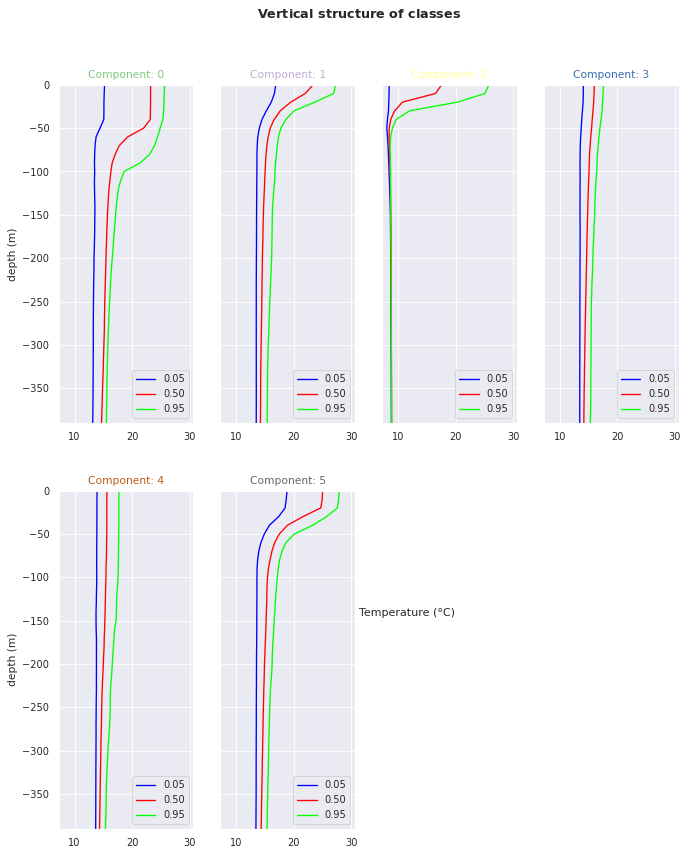

In [77]:
P.vertical_structure(q_variable = var_name_ds + '_Q', sharey=True, xlabel='Temperature (°C)')

In [78]:
P.spatial_distribution()

ValueError: Dimensions {'LATITUDE', 'LONGITUDE'} do not exist. Expected one or more of ('sample_dim',)

In [ ]:
%%time
ds_full = ds_full.rename({'labels': 'PCM_LABELS'})
pcm_features = {'temperature': z}
m_pcm = pcm(K=k, features=pcm_features)
P = Plotter(ds_full, m_pcm)

In [ ]:
P.vertical_structure(q_variable = var_name_ds + '_Q', sharey=True, xlabel='Temperature (°C)')

In [ ]:
P.spatial_distribution()